<H1>Anomaly Detection - Clickstream</H1>
<br>:: Anomaly detection is the identification of events in a dataset that do not conform to the expected patterns.  This drives value by detecting unforseen anomalies and integrity to our analytics.
<br>:: Isolation Forrest library, from scikit-learn, will be used for ML algorithm for unsupervised learning.  The base model for this will be utilizing decision tree model.
<br>:: Isolation Forrest isolates each data point by selecing a random feature and then selects a split value between the min and max of the randomly selected feature to measure the path length in order to isolate the data point. A tree is created for all group until each data point is isolated.  The outliers are determined by the loweest number of branches from the main tree (path length) to isolate each data point.
<br>:: Anomaly Score Function which uses the expected average path length of each data point and  divides by the average path length of all data points.
</br>

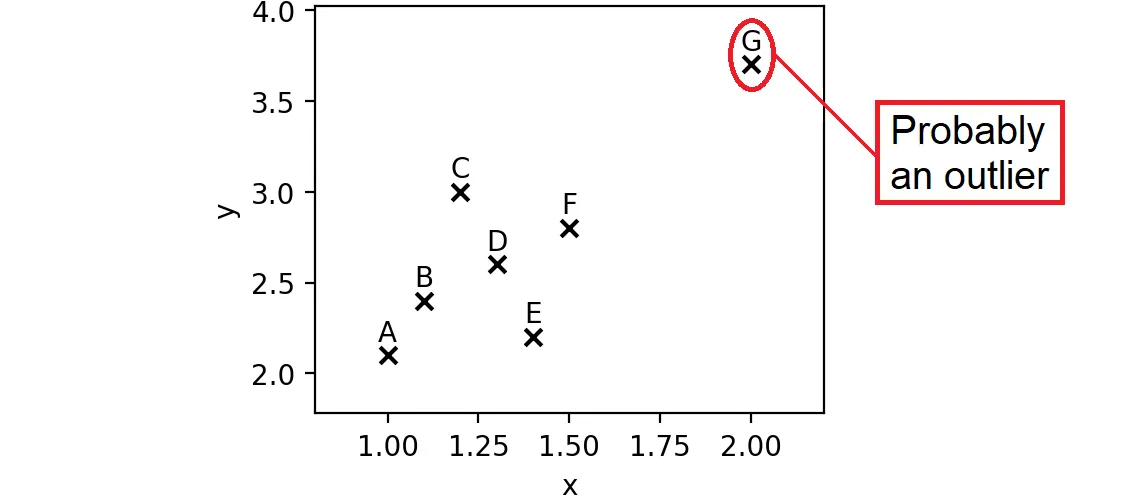

The idea behind Isolation Forest is that, on average, outliers will be closer to the root node (i.e. at a lower depth) than normal instances. we randomly fit many decision trees, and then take an average of the depth of each observation over the different trees, we find an “average depth” that represents a measure of “outlierness”.



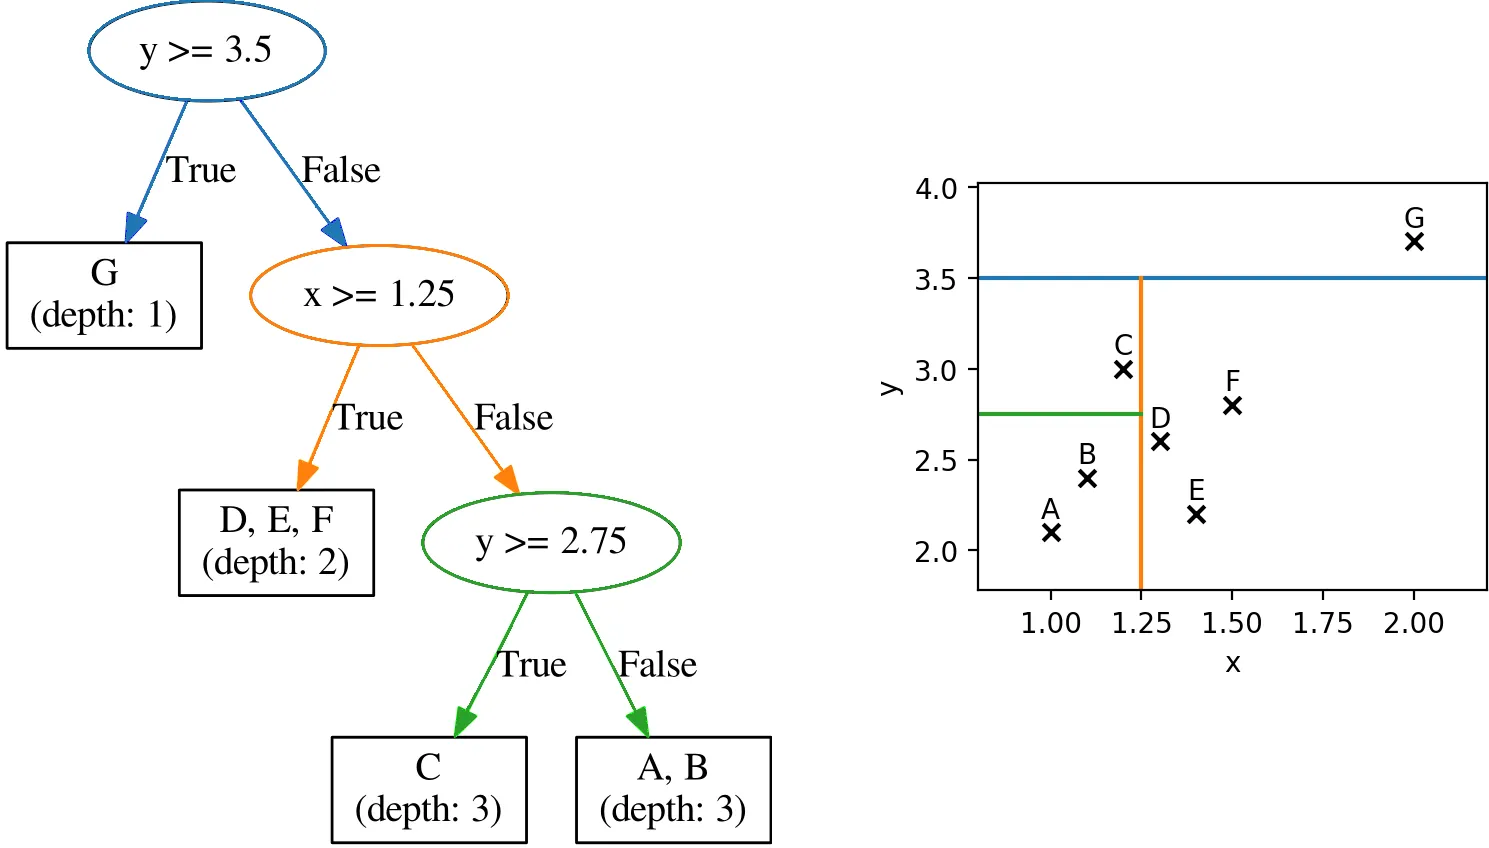

<h2>Import Python Packages</h2>

In [6]:
## Import all python pacakeges needed for feature engineering and modeling
import snowflake.connector
import snowflake.snowpark as snowpark
from snowflake.snowpark import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.functions import col
## Import pacakeges needed for feature engineering and data exploration
from datetime import date
from datetime import datetime
import numpy as np
import pandas as pd
## Import plotting libraries
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sn
import cufflinks as cf
import chart_studio.plotly as py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
## To make plotly work with Jupyter Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline
## Import ML Library for Isolation Forrest
from sklearn.ensemble import IsolationForest

<H2>Creating Snowpark Session</H2>

In [9]:
## Create session to connect to Snowflake
def snowpark_session_create():
    snowflake_connection_parameters = {
       "account" : "lifetime.east-us-2.azure"
      ,"user" : "RPATEL2@LT.LIFE"
      #,"password" : ""
      ,"warehouse" : "ANALYSTS_MEDIUM_WH"  
      ,"role": "DataEngineers"  
      ,"authenticator" : "externalbrowser"  
    }

    snowpark_session = Session.builder.configs(snowflake_connection_parameters).create()
    return snowpark_session

In [10]:
## Create a demo_session using the above defined session.  This will open the SSO to get connected to Snowpark
demo_session = snowpark_session_create()

<h2>Selecting using sql with snowpark</h2>

In [11]:
snowpark_df = demo_session.sql("select * from prod_lt_udw.sandbox.t_mobile_clickstream_agg")

In [12]:
desc_result = snowpark_df.describe().sort("SUMMARY").show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"YEAR"  |"MONTH_NAME"  |"MONTH"             |"WEEK"             |"HOUR"             |"DAY_NAME"  |"DAY"              |"UNIQUE_VISITS"     |"UNIQUE_MEMBERS"  |"RESERVATIONS_COMPLETED"  |"SUCCESSFUL_SIGN_IN"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|count      |5135.0  |5135          |5135.0              |5135.0             |5135.0             |5135        |5135.0             |5135.0              |5135.0            |5135.0                    |5135.0                |
|max        |2023.0  |May           |8.0                 |52.0               |23.0               |Wed         |3

In [13]:
# Show  using snowpark sql
#snowpark_df.show(3)
df_pd = snowpark_df.to_pandas()

df_pd.head()


VISIT_DATE  YEAR MONTH_NAME  MONTH  WEEK  HOUR DAY_NAME  DAY  \
0  2023-05-08  2023        May      5    19    16      Mon    8   
1  2023-05-08  2023        May      5    19     2      Mon    8   
2  2023-05-08  2023        May      5    19     4      Mon    8   
3  2023-05-08  2023        May      5    19    23      Mon    8   
4  2023-05-08  2023        May      5    19    12      Mon    8   

   UNIQUE_VISITS  UNIQUE_MEMBERS  RESERVATIONS_COMPLETED  SUCCESSFUL_SIGN_IN  
0          34701           31755                    5760                 858  
1           1289            1147                     401                  43  
2           7328            6839                    1116                 177  
3           6151            5459                    1915                 206  
4          21810           19636                    5333                 722

In [14]:
df_pd["VISIT_DATE2"] = pd.to_datetime(df_pd["VISIT_DATE"])
df_pd.head()
print(df_pd.dtypes)

VISIT_DATE                        object
YEAR                               int16
MONTH_NAME                        object
MONTH                               int8
WEEK                                int8
HOUR                                int8
DAY_NAME                          object
DAY                                 int8
UNIQUE_VISITS                      int32
UNIQUE_MEMBERS                     int32
RESERVATIONS_COMPLETED             int16
SUCCESSFUL_SIGN_IN                 int16
VISIT_DATE2               datetime64[ns]
dtype: object


<h3>Select using Snowpark Python</h3>

In [16]:
### You can define the below parameters so that we don't have to keep using "demo_session" repeatedly 
## Define the session to the database so that we don't have to keep typing out
demo_session.use_database("prod_lt_udw")
## Define the session tot he schema we want to use
demo_session.use_schema("sandbox")
## Define the warehouse you want to use
demo_session.use_warehouse("ANALYSTS_MEDIUM_WH")
## Define the table that is going to be used
s_df=demo_session.table("t_mobile_clickstream_agg")

<h2>Daily Resrvations Completed</h2>

In [17]:
fig = px.bar(df_pd.reset_index(), x='VISIT_DATE', y='RESERVATIONS_COMPLETED', title='RESERVATIONS_COMPLETED')

fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()

(array([19358., 19389., 19417., 19448., 19478., 19509., 19539., 19570.]),
 [Text(19358.0, 0, '2023-01'),
  Text(19389.0, 0, '2023-02'),
  Text(19417.0, 0, '2023-03'),
  Text(19448.0, 0, '2023-04'),
  Text(19478.0, 0, '2023-05'),
  Text(19509.0, 0, '2023-06'),
  Text(19539.0, 0, '2023-07'),
  Text(19570.0, 0, '2023-08')])

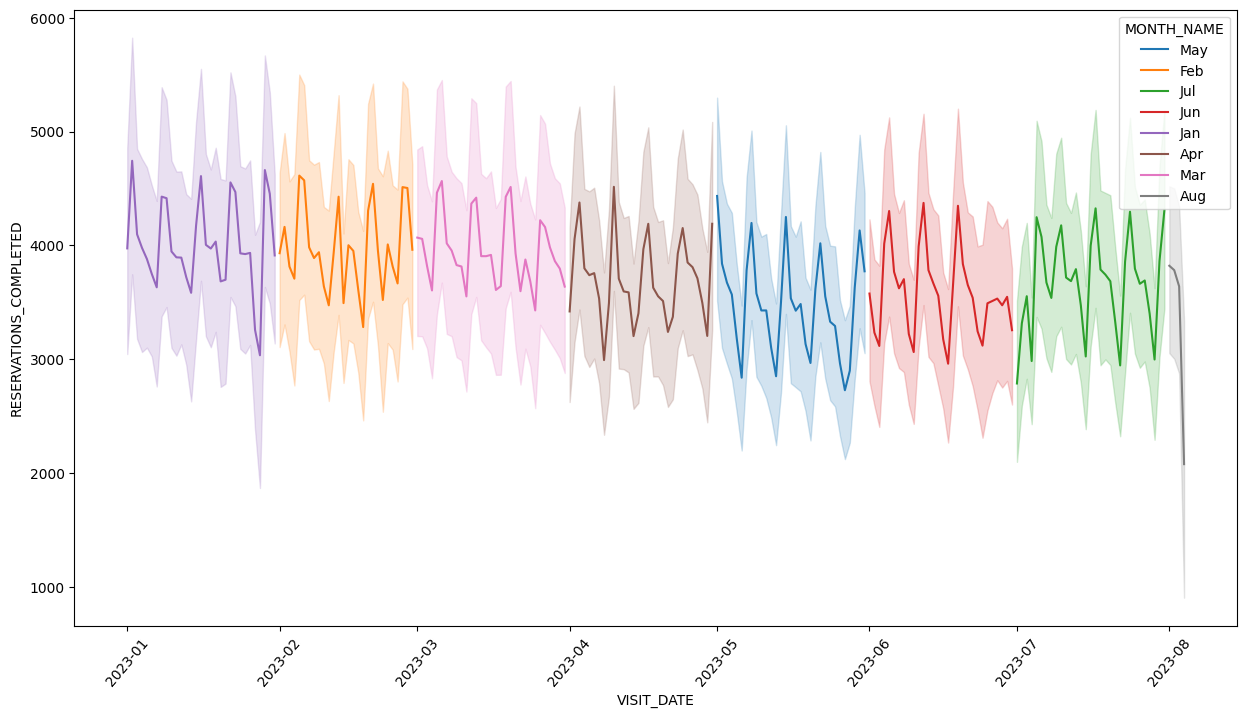

In [18]:
plt.figure(figsize=(15,8))

sn.lineplot(x = "VISIT_DATE", y = "RESERVATIONS_COMPLETED", hue = 'MONTH_NAME',
             data = df_pd)
  
plt.xticks(rotation = 50)

<Axes: xlabel='DAY_NAME', ylabel='RESERVATIONS_COMPLETED'>

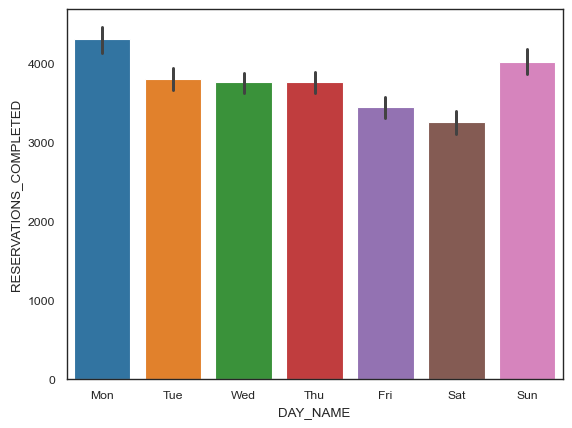

In [39]:
sn.barplot(x='DAY_NAME', y='RESERVATIONS_COMPLETED', data=df_pd)

<Axes: xlabel='HOUR'>

<Figure size 1500x800 with 0 Axes>

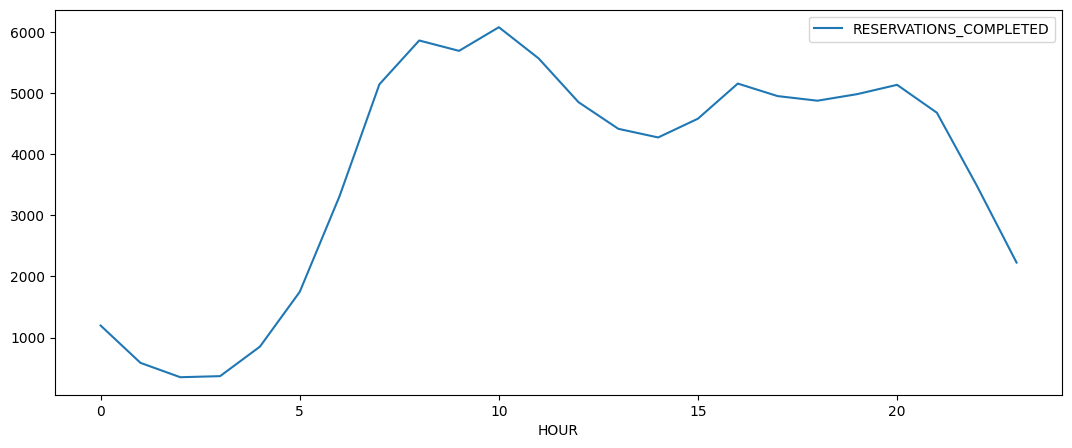

In [19]:
plt.figure(figsize=(15,8))
df_pd[['RESERVATIONS_COMPLETED','HOUR']].groupby('HOUR').mean().plot(figsize=(13, 5))

<Axes: xlabel='DAY_NAME'>

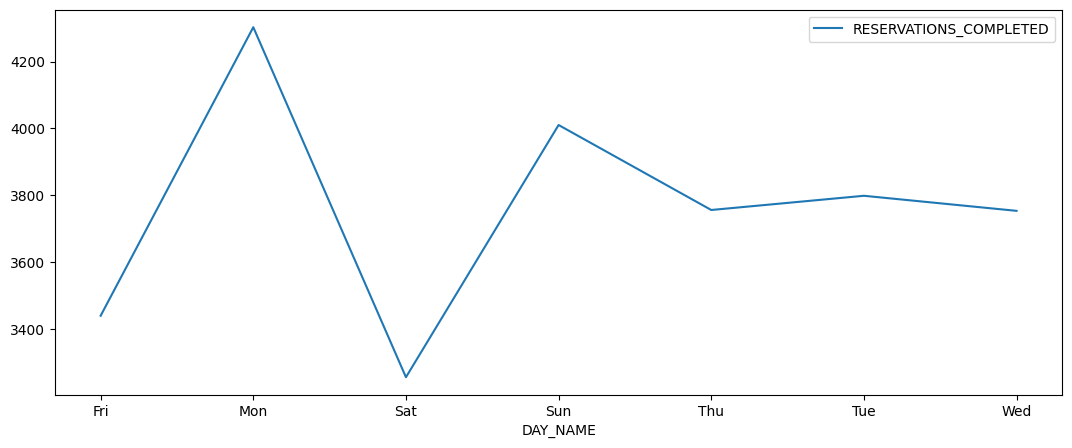

In [20]:
df_pd[['RESERVATIONS_COMPLETED','DAY_NAME']].groupby('DAY_NAME').mean().plot(figsize=(13, 5))

/var/folders/p2/w3_mv0r50pnf_y1yzwrm1wzrrbhd_l/T/ipykernel_35601/2132199089.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



<Axes: xlabel='HOUR'>

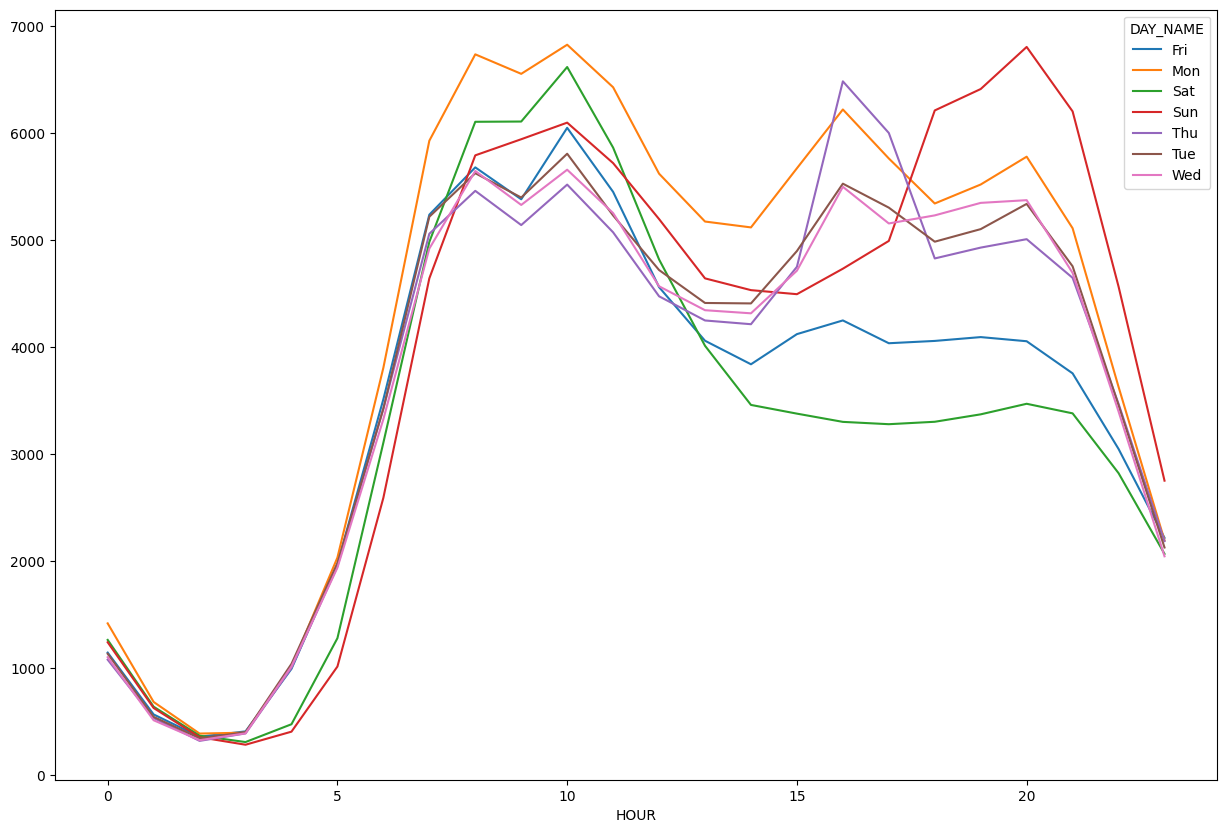

In [21]:
df_pd.groupby(['HOUR', 'DAY_NAME']).mean()['RESERVATIONS_COMPLETED'].unstack().plot(figsize=(15, 10))

In [22]:
px.line(df_pd.reset_index(),y=['SUCCESSFUL_SIGN_IN', 'RESERVATIONS_COMPLETED', 'UNIQUE_VISITS'],
    labels={'x':'VISIT_DATE2', 'y':'conversions'},
       title='Conversion')

/var/folders/p2/w3_mv0r50pnf_y1yzwrm1wzrrbhd_l/T/ipykernel_35601/350311152.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='RESERVATIONS_COMPLETED'>

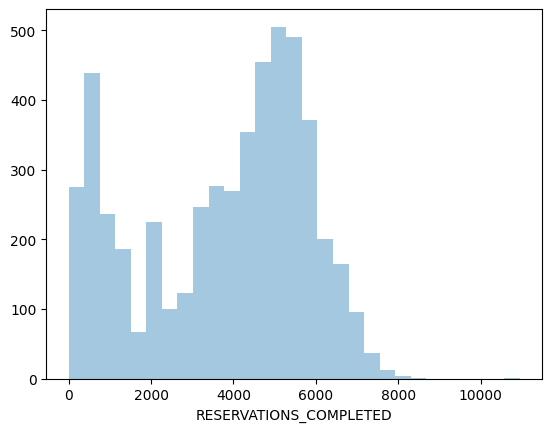

In [26]:
sn.distplot(df_pd['RESERVATIONS_COMPLETED'], kde=False)

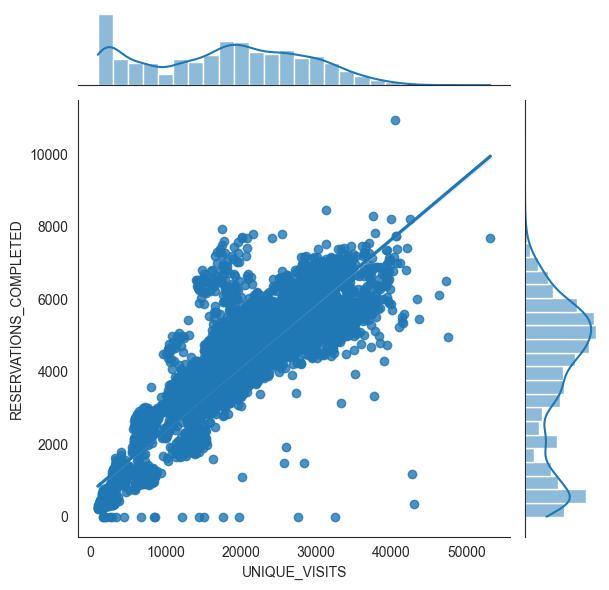

In [31]:
sn.set_style('white')

sn.jointplot(x='UNIQUE_VISITS', y='RESERVATIONS_COMPLETED', data=df_pd, kind='reg')

<Axes: xlabel='HOUR', ylabel='RESERVATIONS_COMPLETED'>

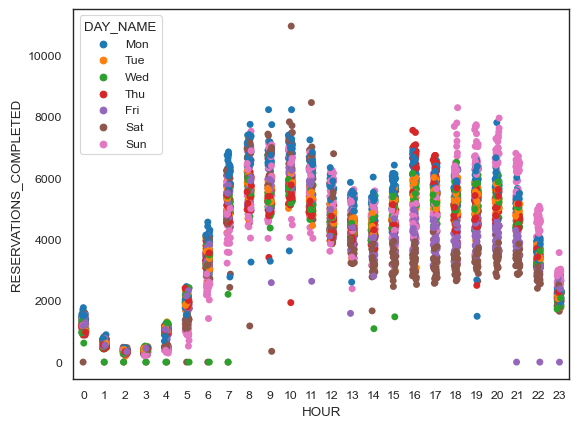

In [42]:
sn.stripplot(x='HOUR', y='RESERVATIONS_COMPLETED', data=df_pd, jitter=True, hue='DAY_NAME')

/Users/e9003863/desktop/analytics/yes/envs/snowpark/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



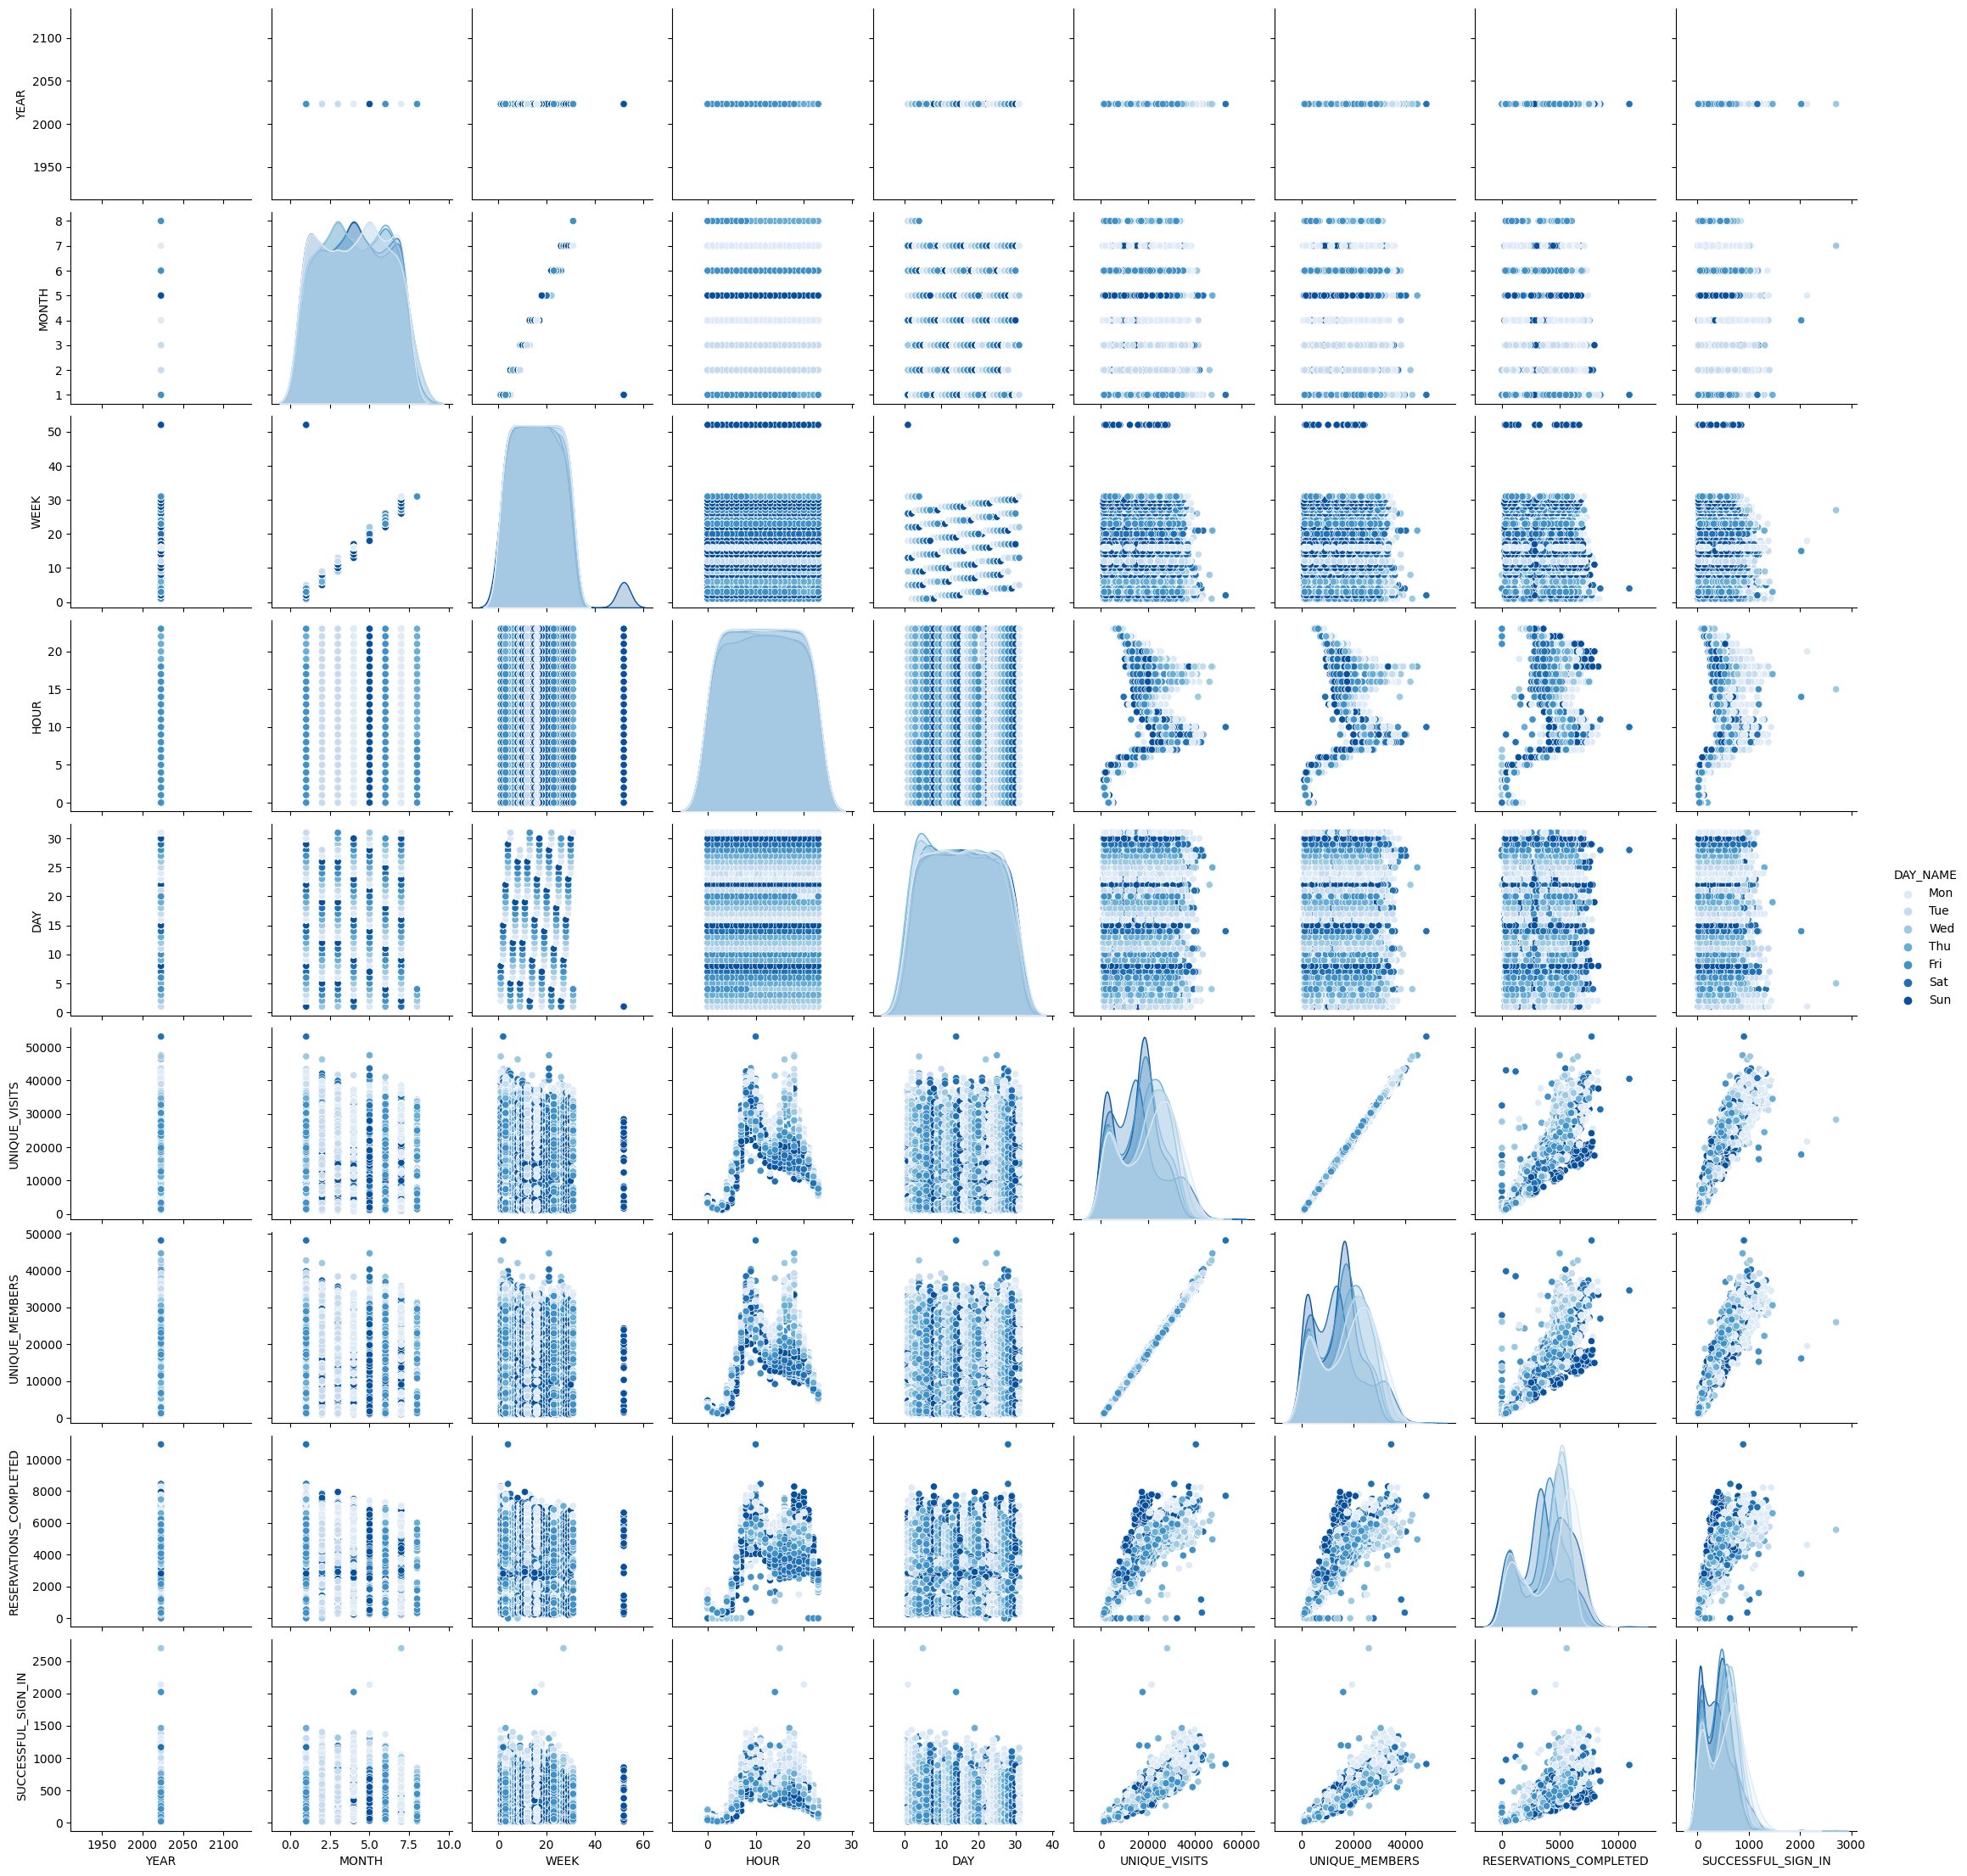

In [30]:
sn.pairplot(df_pd, hue='DAY_NAME', palette='Blues')

In [108]:
# Adding Column to dataframe with unique visits ave for day_name and hour compbination
df_final=df_pd.join(
    df_pd.groupby
        (['HOUR','DAY_NAME'])['UNIQUE_VISITS'].mean(), on=['HOUR','DAY_NAME'], rsuffix='_AVG_HOUR_DAY')

In [109]:
df_final.head()

VISIT_DATE  YEAR MONTH_NAME  MONTH  WEEK  HOUR DAY_NAME  DAY  \
0  2023-05-06  2023        May      5    18    15      Sat    6   
1  2023-05-06  2023        May      5    18    10      Sat    6   
2  2023-05-06  2023        May      5    18    11      Sat    6   
3  2023-05-06  2023        May      5    18     5      Sat    6   
4  2023-05-06  2023        May      5    18    12      Sat    6   

   UNIQUE_VISITS  UNIQUE_MEMBERS  RESERVATIONS_COMPLETED  SUCCESSFUL_SIGN_IN  \
0          13977           12810                    2650                 417   
1          29662           26789                    5610                 824   
2          23978           21699                    5129                 702   
3           6356            5801                    1328                 123   
4          19425           17738                    4049                 693   

   UNIQUE_VISITS_AVG_HOUR_DAY  
0                16223.923077  
1                32582.307692  
2                27201.384615  
3                 6544.818182  
4                22470.615385

# Create DF_FINAL for Modeling

In [112]:
df_final = df_final[['UNIQUE_VISITS', 'HOUR', 'DAY', 'VISIT_DATE','UNIQUE_VISITS_AVG_HOUR_DAY']]

In [113]:
df_final.head()

UNIQUE_VISITS  HOUR  DAY  VISIT_DATE  UNIQUE_VISITS_AVG_HOUR_DAY
0          13977    15    6  2023-05-06                16223.923077
1          29662    10    6  2023-05-06                32582.307692
2          23978    11    6  2023-05-06                27201.384615
3           6356     5    6  2023-05-06                 6544.818182
4          19425    12    6  2023-05-06                22470.615385

<h2>Select Dataset for Model</h2>

In [114]:
data = df_pd[['UNIQUE_VISITS', 'HOUR', 'DAY']]

<h2>Fit Data for IsolationForest Model</h2>

In [118]:
model = IsolationForest(contamination=0.005, max_features=3, max_samples=0.8, n_estimators=200)
model.fit(data)

IsolationForest(contamination=0.005, max_features=3, max_samples=0.8,
                n_estimators=200)

In [119]:
df_final['OUTLIERS'] = pd.Series(model.predict(data)).apply(lambda x: 'yes' if (x == -1) else 'NO')

<h4>Output showing the Date and Hour in which unique visits were an outlier</h4>

In [120]:
df_final.query('OUTLIERS=="yes"')

UNIQUE_VISITS  HOUR  DAY  VISIT_DATE  UNIQUE_VISITS_AVG_HOUR_DAY  \
190           38400    18   28  2023-06-28                29997.642857   
193           40996    17   28  2023-06-28                33388.642857   
351           39435    18    9  2023-05-09                30419.071429   
517           39035    16   30  2023-06-30                23113.615385   
551            5176     0    1  2023-07-01                 4435.769231   
1328           5367     0    4  2023-07-04                 3830.214286   
1638          47510    18   25  2023-05-25                28200.071429   
1674          40126    10   26  2023-05-26                29884.846154   
2081           4925     0   31  2023-05-31                 4203.285714   
2146          38339    17    1  2023-05-01                34730.928571   
2198          41421     8   27  2023-05-27                34613.230769   
2201          43587     9   27  2023-05-27                35475.692308   

     OUTLIERS  
190       yes  
193       yes  
351       yes  
517       yes  
551       yes  
1328      yes  
1638      yes  
1674      yes  
2081      yes  
2146      yes  
2198      yes  
2201      yes

In [122]:
fig = px.scatter(df_final, x='VISIT_DATE', color='OUTLIERS', hover_data=['DAY','HOUR','UNIQUE_VISITS_AVG_HOUR_DAY'],title='UNIQUE_VISITS Anomalies')

fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()                 

<h2>Scoring Anomaly Model</h2>

In [100]:
score=model.decision_function(data)

NameError: name 'model' is not defined

In [89]:
score

array([0.0844708 , 0.14747602, 0.15768889, ..., 0.13604853, 0.05152057,
       0.12103057])

In [99]:
plt.hist(score, bins=80)

NameError: name 'score' is not defined

In [95]:
df_pd.columns
df_heat=df_pd[['VISIT_DATE','MONTH_NAME','DAY_NAME','RESERVATIONS_COMPLETED']]
df

DAY_NAME             Fri           Mon           Sat           Sun  \
MONTH_NAME                                                           
Apr         16017.843750  19953.093750  15056.041667  14427.825000   
Aug         11278.222222           NaN           NaN           NaN   
Feb         16982.833333  20062.781250  16142.625000  15429.604167   
Jan         17052.521739  20991.583333  17048.864583  16221.666667   
Jul         16457.562500  20198.033333  15253.814159  14828.136752   
Jun         16978.754386  20130.168421  15230.584270  14709.623656   
Mar         16401.516667  19893.541667  15837.895833  15171.747368   
May         15978.385417  19624.333333  14426.937500  13600.104167   

DAY_NAME             Thu           Tue           Wed  
MONTH_NAME                                            
Apr         17321.635417  19036.854167  18667.166667  
Aug         18309.208333  19679.541667  19246.083333  
Feb         18368.218750  18764.062500  19748.666667  
Jan         18541.437500  19999.966667  19915.750000  
Jul         18372.114583  18935.322917  19286.750000  
Jun         18536.491525  19798.166667  19771.864583  
Mar         17762.583333  19015.489583  19058.400000  
May         17525.000000  19514.391667  19157.858333

In [97]:
df=df_heat.pivot_table(index='MONTH_NAME', columns='DAY_NAME', values='RESERVATIONS_COMPLETED', aggfunc='mean')

<Axes: xlabel='DAY_NAME', ylabel='MONTH_NAME'>

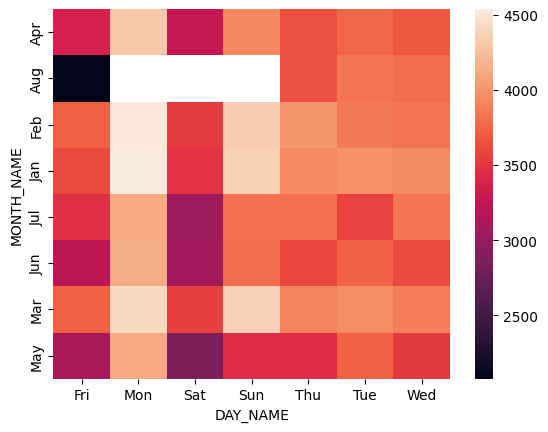

In [98]:
sn.heatmap(df)